In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vurvikkorukonda","key":"8b4b93ba6b8e4ac71d53374cb5e4d7c5"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shubham2703/five-crop-diseases-dataset -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/shubham2703/five-crop-diseases-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
import os

dataset_path = "/content/data"
print("Dataset files:", os.listdir(dataset_path))


Dataset files: ['Crop Diseases Dataset']


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Wheat dataset

Image shape: (168, 456, 3)


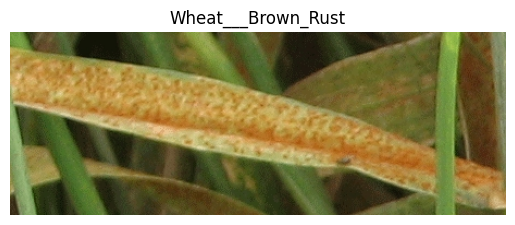

In [ ]:
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Wheat/",
                        target_class="Wheat___Brown_Rust")

Image shape: (856, 1292, 3)


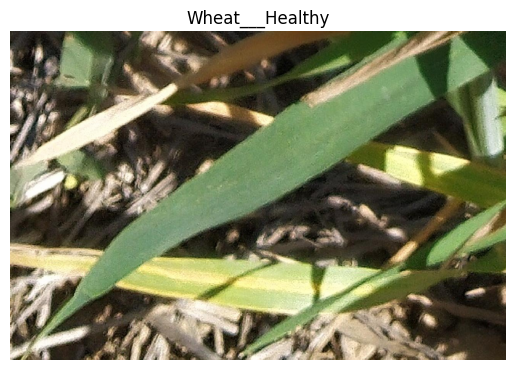

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Wheat/",
                        target_class="Wheat___Healthy")

Image shape: (136, 160, 3)


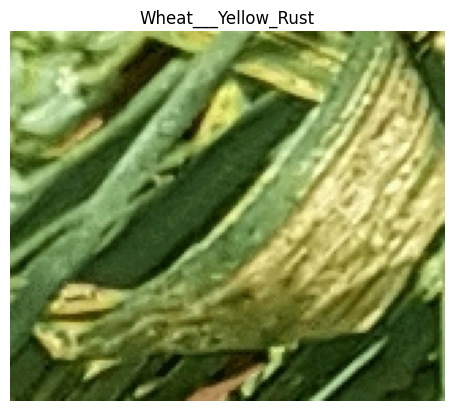

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Wheat/",
                        target_class="Wheat___Yellow_Rust")

In [ ]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Wheat'

In [ ]:
class_names=dataset.class_names
class_names

['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']

In [ ]:
len(dataset)

92

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 2 1 1 2 1 0 1 1 2 2 2 0 1 0 2 0 1 0 1 1 0 0 1 0 2 2 2 2 0 2]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2942 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + val_split + test_split) == 1

    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # freeze the convolutional base

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # Adjust '3' for your number of classes

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [ ]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accuracy: 0.3977 - loss: 4.2470 - val_accuracy: 0.7535 - val_loss: 0.7946
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 407ms/step - accuracy: 0.6224 - loss: 1.7130 - val_accuracy: 0.8715 - val_loss: 0.3014
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.7529 - loss: 0.9009 - val_accuracy: 0.9097 - val_loss: 0.2484
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.7939 - loss: 0.6428 - val_accuracy: 0.9340 - val_loss: 0.1830
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.8429 - loss: 0.4807 - val_accuracy: 0.9444 - val_loss: 0.1813
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 399ms/step - accuracy: 0.8719 - loss: 0.3936 - val_accuracy: 0.9722 - val_loss: 0.1148
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step - accuracy: 0.8707 - loss: 0.3709 - val_accuracy: 0.9549 - val_loss: 0.1120
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - accuracy: 0.8995 - loss: 0.3045 - val_accu

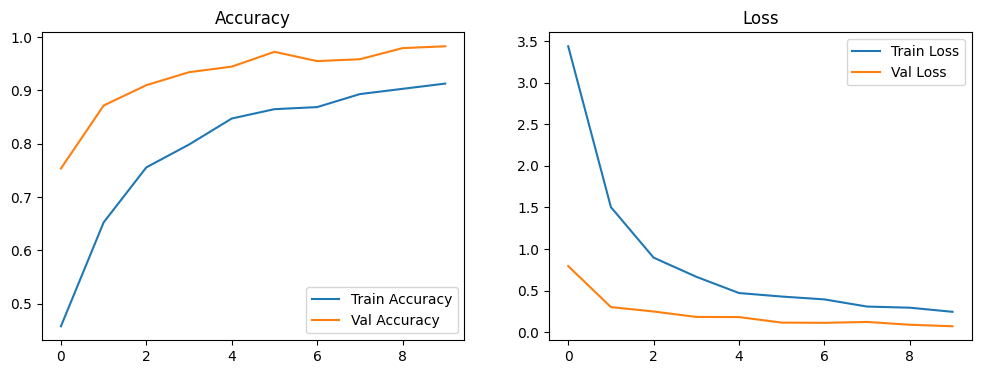

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # add batch dimension
    img_array = img_array / 255.0  # normalize

    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()
    confidence = tf.reduce_max(predictions[0]).numpy()

    return predicted_class, confidence

# Example usage
img_path = "/content/Yellow_rust004.jpg"
pred_class, confidence = predict_image(img_path, model_vgg)
print(f"Predicted Class: {pred_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Class: 2, Confidence: 0.37


In [ ]:
model_vgg.save("crop_disease_model_wheat_vgg16.keras")  # Save in native Keras format


Rice Diease classification

Image shape: (256, 256, 3)


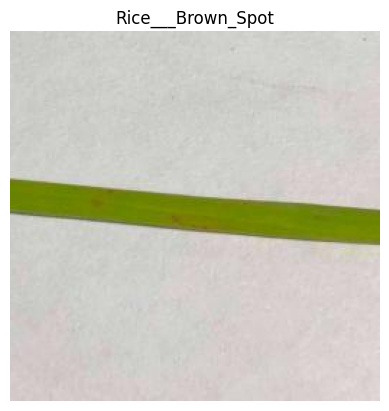

In [ ]:
import os
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/",
                        target_class="Rice___Brown_Spot")

Image shape: (256, 256, 3)


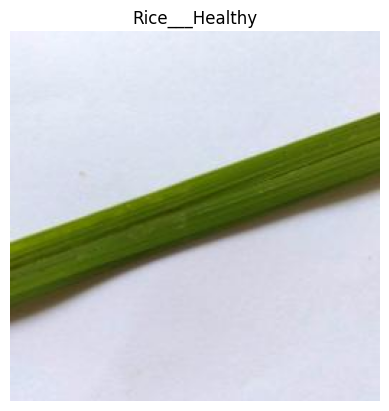

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/",
                        target_class="Rice___Healthy")

Image shape: (256, 256, 3)


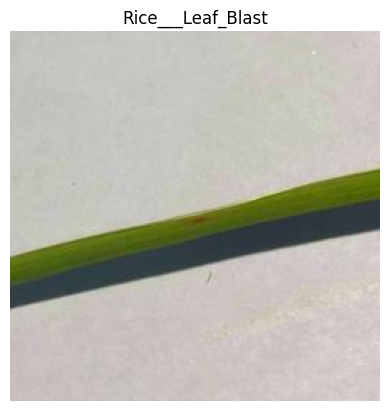

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/",
                        target_class="Rice___Leaf_Blast")

Image shape: (3120, 3120, 3)


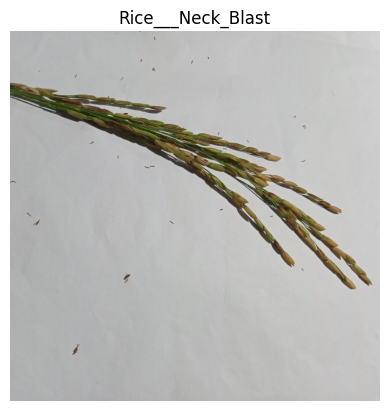

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/",
                        target_class="Rice___Neck_Blast")

In [ ]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4078 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Leaf_Blast',
 'Rice___Neck_Blast']

In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze convolution layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation='softmax')(x)

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [ ]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 736ms/step - accuracy: 0.3814 - loss: 3.1230 - val_accuracy: 0.6589 - val_loss: 0.9275
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 79s 778ms/step - accuracy: 0.5072 - loss: 1.5033 - val_accuracy: 0.6667 - val_loss: 0.7996
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 730ms/step - accuracy: 0.5821 - loss: 1.1306 - val_accuracy: 0.6849 - val_loss: 0.7321
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 78s 771ms/step - accuracy: 0.6243 - loss: 0.9643 - val_accuracy: 0.6927 - val_loss: 0.6846
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 75s 732ms/step - accuracy: 0.6263 - loss: 0.8836 - val_accuracy: 0.7083 - val_loss: 0.6334
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 76s 743ms/step - accuracy: 0.6768 - loss: 0.7558 - val_accuracy: 0.6849 - val_loss: 0.6839
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 76s 745ms/step - accuracy: 0.6908 - loss: 0.7166 - val_accuracy: 0.6901 - val_loss: 0.6514
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 77s 761ms/step - accuracy: 0.6984 - loss: 0

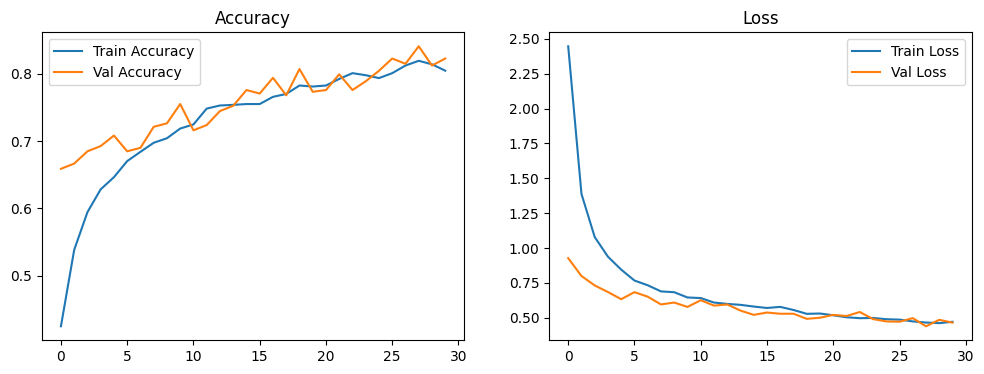

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()

    return predicted_class, confidence

# Usage example
img_path = "/content/neckblast.jpg"
predicted_class, conf = predict_image(img_path, model_vgg)
print(f"Predicted class: {predicted_class}, Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: 3, Confidence: 0.64


In [ ]:
model_vgg.save("crop_disease_rice_model_vgg16.keras")

sugarcane model


Image shape: (3456, 5184, 3)


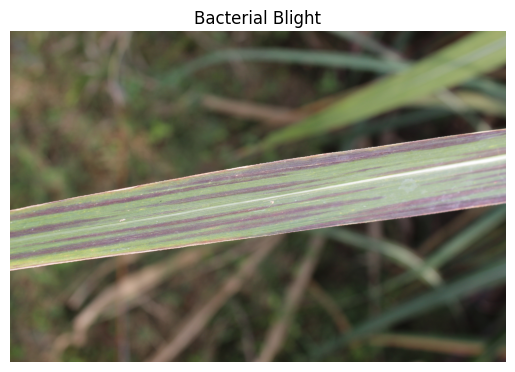

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Bacterial Blight")

Image shape: (3024, 4032, 3)


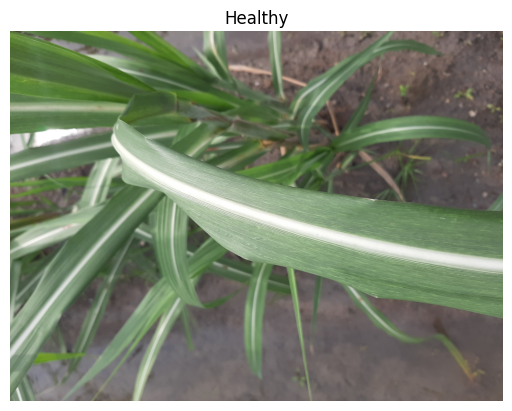

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Healthy")

Image shape: (3456, 5184, 3)


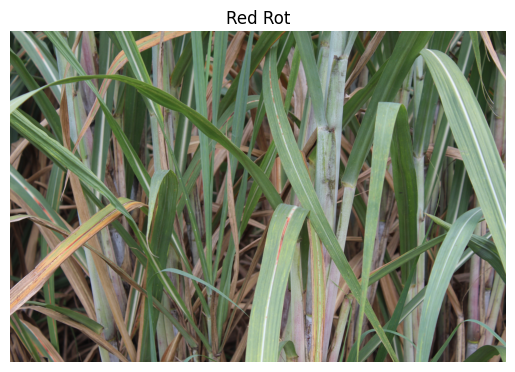

In [ ]:
# View a random image from the dataset
img = view_random_image(target_dir="data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/",
                        target_class="Red Rot")

In [ ]:
directory_path = r'data/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 15

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 300 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)  # ⬅️ Change 3 if you have a different number of classes

model_vgg = models.Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', save_best_only=True)


In [ ]:
history = model_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/15
